In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
# from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff import Kirchhoff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MODEL AND GEOM DEFINITON

In [54]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Microseismic source
xmicro = [nx//2, nx//4]
zmicro = [nz//2, nz//4]
ampmicro = [1, 4]
microseismic = np.zeros((nx, nz))
for ix, iz, amp in zip(xmicro, zmicro, ampmicro):
    microseismic[ix, iz] = amp

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]



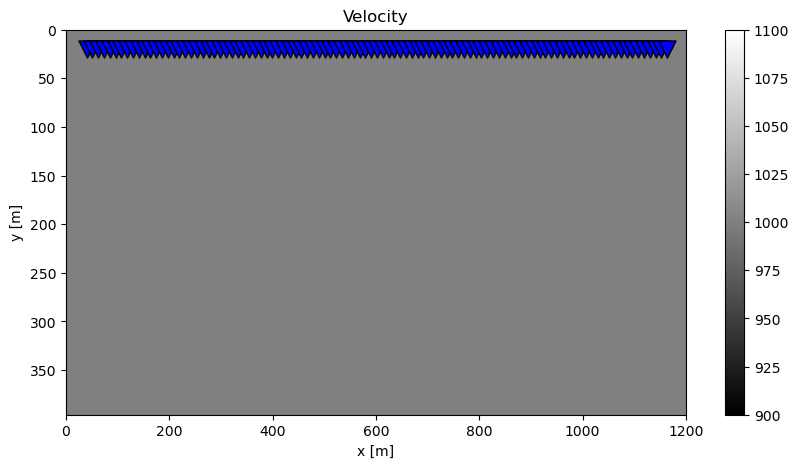

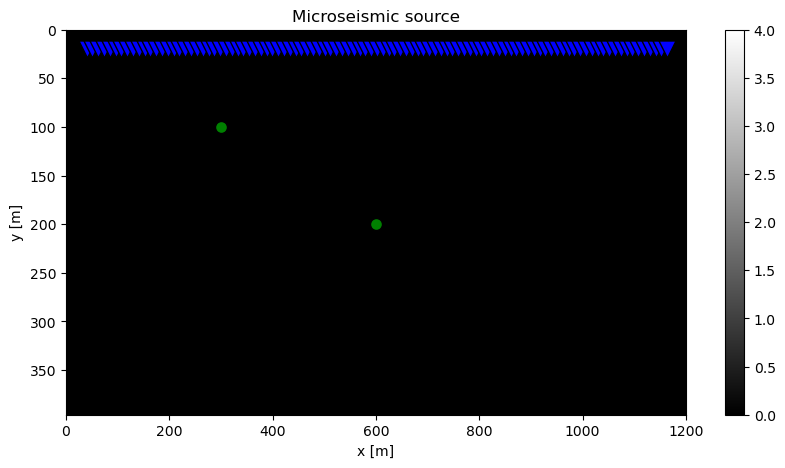

In [55]:
plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(microseismic.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='.', s=300, c='g', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Microseismic source')
plt.xlim(x[0], x[-1]);

# COMPUTE TRAVELTIMES

In [56]:
trav = Kirchhoff._traveltime_table(z, x, recs, recs, v0, mode='analytic')[1]


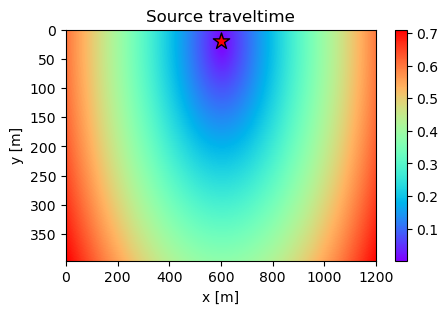

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(trav[:, nr//2].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, nr//2], recs[1, nr//2], marker='*', s=150, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Source traveltime')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

In [58]:
microseismic

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# MODEL THE DATA

In [59]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, nr)
travd = travd.reshape(nx, nz, nr)

In [60]:
# INITIALISE OPERATOR
Op = Kirchhoff(z, x, t, recs[:, :1], recs, v0, wav, wavc, mode='analytic', engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=5575.29289743482 - u^H(Op^Hv)=5575.292897434815


In [61]:
# PERFORM FORWARD (MODEL)
micro_data = Op @ microseismic

In [62]:
# PERFORM ADJOINT (MIGRATE)
micro_mig = Op.H @ micro_data

In [106]:
# Use LSQR to solve  
minv = lsqr(Op, micro_data.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 65751 rows and 30100 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.814e+01  7.814e+01    1.0e+00  2.2e+00
     1 -6.10109e-06   5.450e+01  5.450e+01    7.0e-01  4.4e-01   2.4e+02  1.0e+00
     2 -1.99029e-05   4.116e+01  4.116e+01    5.3e-01  3.5e-01   3.0e+02  2.4e+00
     3 -3.35436e-05   3.255e+01  3.255e+01    4.2e-01  2.6e-01   3.7e+02  4.1e+00
     4 -4.46619e-05   2.753e+01  2.753e+01    3.5e-01  2.0e-01   4.3e+02  5.7e+00
     5 -5.64114e-05   2.374e+01  2.374e+01    3.0e-01  1.8e-01   4.8e+02  7.6e+00
     6 -7.30952e-05   2.013e+01  2.013e+01    2.6e-01  1.8e-01   5.3e+02  9.9e+00
     7 -6.51394e-05   1.743e+01  1.743e+01    2.2e-01  1.4e-01   5.8e+02  1.2e+01
     8  1.08220e-04   1.539e+01 

In [ ]:
# POST-PROCESS
n_evs = 50 
ev_locs = np.array(np.unravel_index(np.argpartition(minv.ravel(), -1*n_evs)[-n_evs:],micro_mig.shape))

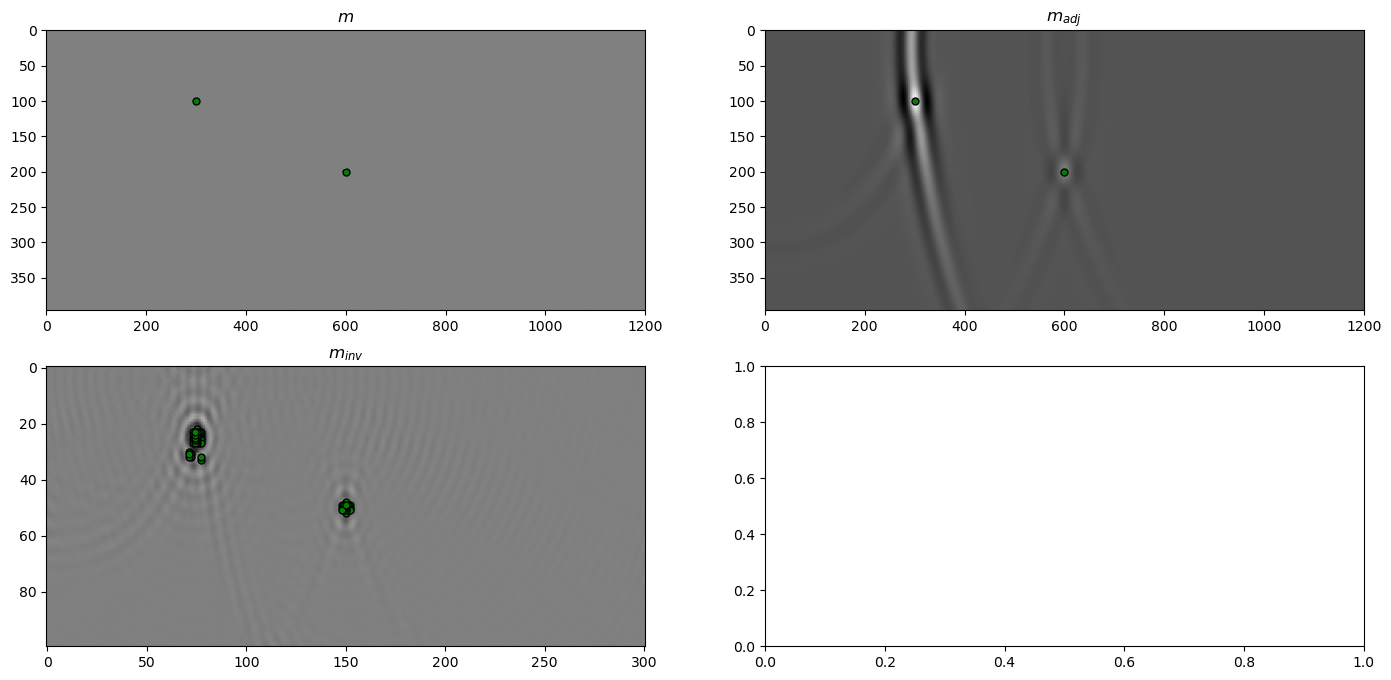

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(17, 8))
axs[0][0].imshow(microseismic.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
axs[0][0].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(micro_mig.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
axs[0][1].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1][0].scatter(ev_locs[0], ev_locs[1], marker='.', s=100, c='g', edgecolors='k')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
# axs[1][1].imshow(minv_sparse.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
# #axs[1][1].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
# axs[1][1].axis('tight')
# axs[1][1].set_title(r'$m_{FISTA}$');

In [76]:
# POST-PROCESS
ev_loc = np.unravel_index(np.argmax(micro_mig),micro_mig.shape)

In [92]:
n_evs = 50 
ev_locs = np.array(np.unravel_index(np.argpartition(micro_mig.ravel(), -1*n_evs)[-n_evs:],micro_mig.shape))

In [90]:
ev_locs[0]

array([75, 76, 74, 76, 76, 75, 74, 75, 74, 74, 74, 76, 76, 76, 74, 75, 75,
       75, 75, 75])

(-0.5, 300.5, 99.5, -0.5)

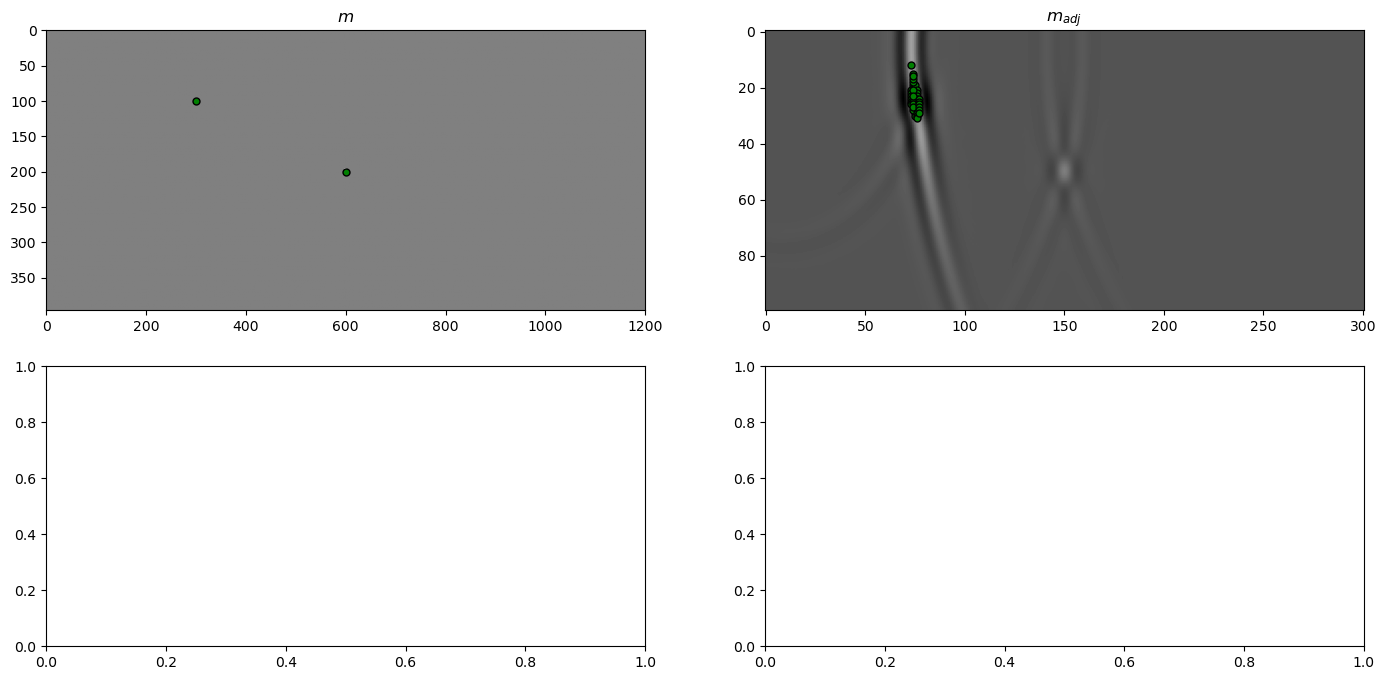

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(17, 8))
axs[0][0].imshow(microseismic.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
axs[0][0].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')

axs[0][1].imshow(micromig.T, cmap='gray')
axs[0][1].scatter(ev_locs[0], ev_locs[1], marker='.', s=100, c='g', edgecolors='k')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')

In [23]:
y = Kirchhoff._travsrcrec_kirch_matvec(microseismic.ravel(),
                                       y=np.zeros([nr,nt]),
                                       nr=nr,
                                       nt=nt,
                                       ni=nx*nz,
                                       dt=dt,
                                       trav_recs=trav
                                      )

cop = Convolve1D(h=wav, offset=wavc,
                 dims=(nr, nt), axis=1)
d = cop * y


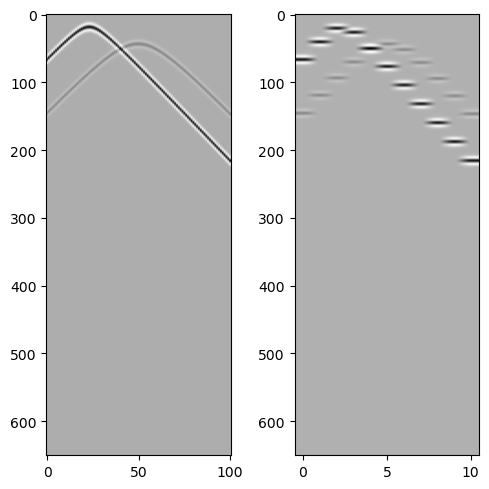

In [24]:
fig,axs = plt.subplots(1,2,figsize=[5,5])
axs[0].imshow(d.T, aspect='auto', cmap='binary')
axs[1].imshow(d[::10].T, aspect='auto', cmap='binary')
plt.tight_layout()

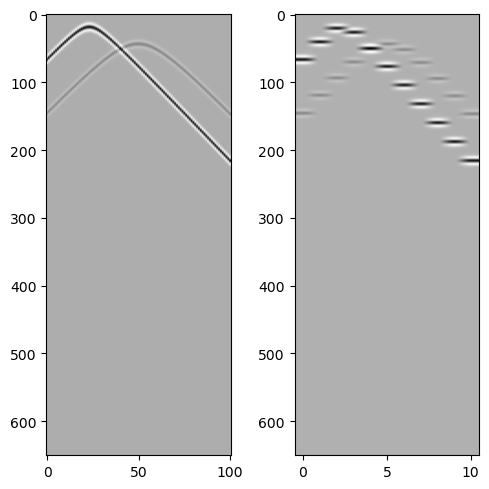

In [49]:
Op = Kirchhoff(z, x, t, recs[:, :1], recs, v0, wav, wavc, mode='analytic', engine='numba')

d1 = Op @ microseismic

fig,axs = plt.subplots(1,2,figsize=[5,5])
axs[0].imshow(d1.T, aspect='auto', cmap='binary')
axs[1].imshow(d1[::10].T, aspect='auto', cmap='binary')
plt.tight_layout()

(0.0, 1200.0, 396.0, 0.0)

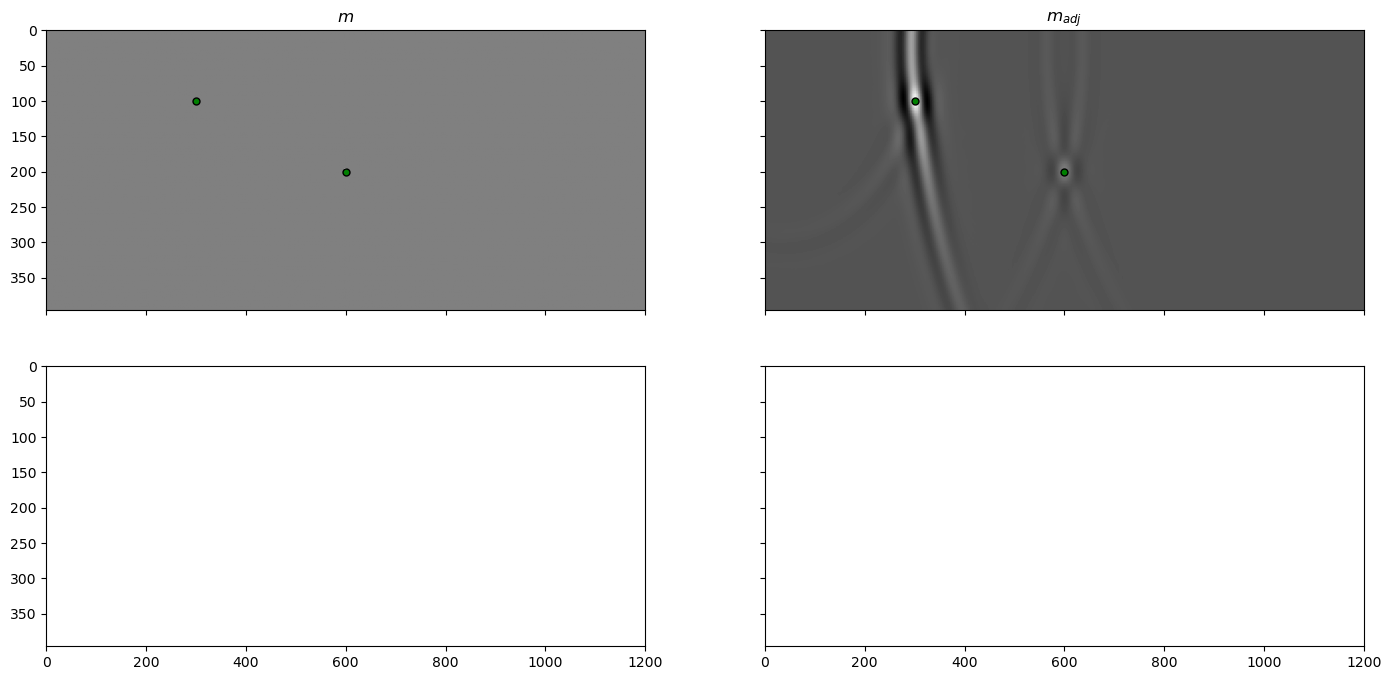

In [50]:
#micromig = Op.rmatvec(d1)
micromig = Op.H @ d1

fig, axs = plt.subplots(2, 2, figsize=(17, 8), sharey=True, sharex=True)
axs[0][0].imshow(microseismic.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
axs[0][0].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(micromig.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
axs[0][1].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')